Тестовое задание
================

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pandas as pd
pd.set_option('display.max_rows', None)

## Pandas

Файл `task_history.csv` содержит исторические данные системы сборки (e.g. *jenkins*, *teamcity*, etc.)

Каждая запись в истории описывает отдельный запуск задачи `build_name` на рабочей машине `worker`.<br/>
Для любого запуска известны автор `author` и проект `project`, в рамках которого был запущен расчет данной задачи.

In [2]:
df = pd.read_csv('task_history.csv', parse_dates=['start_time', 'finish_time'])

df['date'] = df['start_time'].dt.date
df['duration'] = (df.finish_time - df.start_time).dt.total_seconds() / 3600
df['week'] = df['start_time'].dt.isocalendar().week
df['week'] -= df['week'].min() - 1
df['weekday'] = df['start_time'].dt.dayofweek
df['day'] = df['start_time'].dt.strftime('%m-%d')  

### Задача 1

Для каждой недели распечатайте топ-3 пользователей, потребивших наибольшее количество машиночасов.

Выведите для данных пользователей процент потребленных ресурсов от общего объема расчетов за эту неделю.

In [3]:
total_time = df.groupby('week')['duration'].sum()
week_consumption = (df.groupby(['week', 'author'])['duration'].sum() / total_time * 100).round(2)
result = week_consumption.groupby('week').nlargest(3, keep='all').reset_index(level=0, drop=True)
result.rename('DurationInPercent', inplace=True)
result = result.astype(str) + '%'
print(result)

week  author        
1     Bendy Python      45.61%
      Marsha Koltron     4.71%
      Java Smoozy        2.98%
2     Bendy Python      38.78%
      Marsha Koltron      6.1%
      John Ivanov        4.29%
3     Bendy Python      40.55%
      Java Smoozy        4.91%
      Eric Smith          3.3%
4     Bendy Python      45.52%
      Kenny Ivanov       4.17%
      John Koltron       3.14%
Name: DurationInPercent, dtype: object


### Задача 2

Отобразите график с ежедневным потреблением машинного времени каждым проектом.

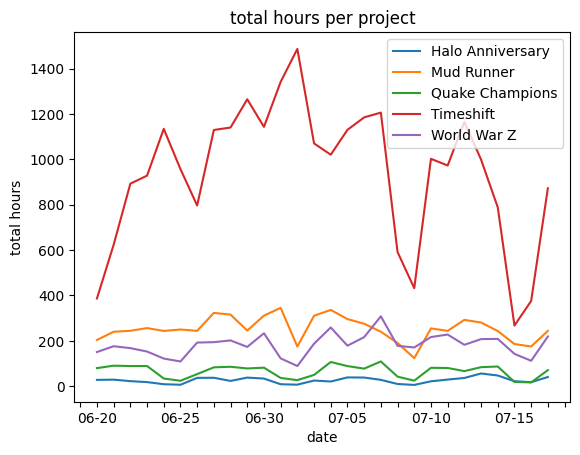

In [11]:
grouped = (df.groupby(['day', 'project'])['duration'].sum()).round(2)
ax = grouped.unstack(level=1).plot(kind='line', ylabel='total hours', xlabel='date', rot=0, title='total hours per project')
ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
plt.legend(loc='upper right')
plt.show()

### Задача 3

Рассмотрим *еженедельное* общее потребление ресурсов. На второй неделе можно заметить всплеск нагрузки с ее последующим планомерным снижением.

Проанализируйте предоставленные данные и найдите, с чем связано подобное поведение.

week
1     9074.09
2    12412.45
3    10498.09
4     9073.23
Name: duration, dtype: float64


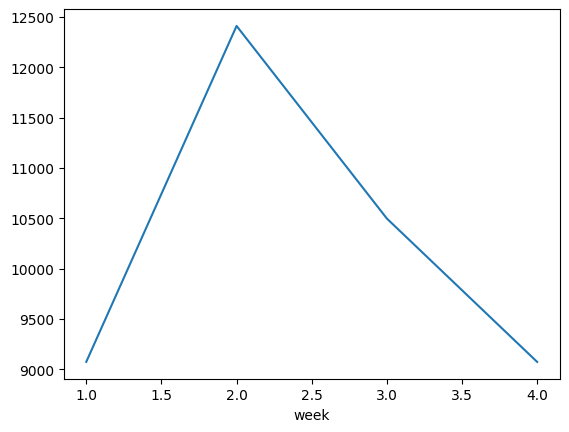

In [13]:
#График недельных нагрузок
df.groupby('week')['duration'].sum().plot()
print(df.groupby('week')['duration'].sum().round(2))

                    count  mean   std  min  25%   50%   75%    max
project                                                           
Halo Anniversary  11732.0  0.06  0.18  0.0  0.0  0.00  0.06   3.81
Mud Runner        27174.0  0.26  0.58  0.0  0.0  0.08  0.31  41.04
Quake Champions   10097.0  0.18  0.31  0.0  0.0  0.02  0.19   2.84
Timeshift         82012.0  0.32  0.65  0.0  0.0  0.10  0.38  29.23
World War Z       29477.0  0.17  0.51  0.0  0.0  0.01  0.20  51.00


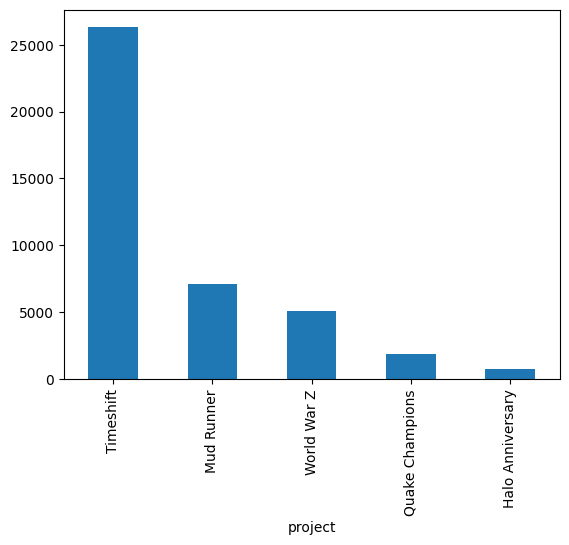

In [6]:
#Суммарная нагрузка в часах по проектам и статистика по ней
df.groupby('project')['duration'].sum().sort_values(ascending=False).plot(kind='bar')
print(df.groupby('project')['duration'].describe().round(2))

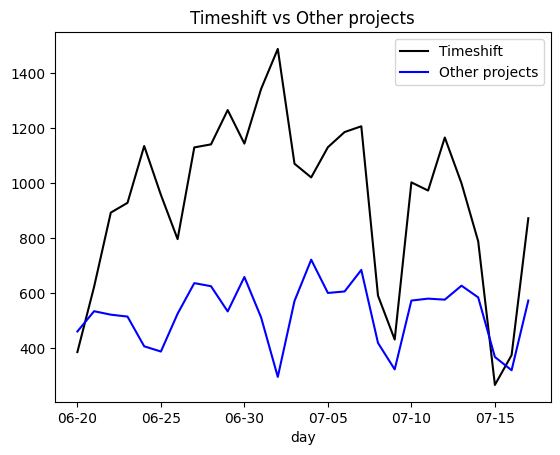

In [7]:
#График машиночасов Timeshift и прочих проектов по дням
fig, ax = plt.subplots()
df.loc[df['project'] == 'Timeshift'].groupby('day')['duration'].sum().plot(c='black', title='Timeshift vs Other projects')
df.loc[df['project'] != 'Timeshift'].groupby('day')['duration'].sum().plot(c='blue')
ax.legend(['Timeshift', 'Other projects'])


## Python

## Задача 4
Слияние логов. <br>
Имеется два файла с логами в формате JSONL, пример лога:
```
{"timestamp": "2021-02-26 08:59:20", "log_level": "INFO", "message": "Hello"}
{"timestamp": "2021-02-26 09:01:14", "log_level": "INFO", "message": "Crazy"}
{"timestamp": "2021-02-26 09:03:36", "log_level": "INFO", "message": "World!"}
```
Сообщения в заданных файлах упорядочены по полю timestamp в порядке возрастания.<br>
Требуется написать функцию, которая объединит эти два файла в один новый файл.<br>
При этом сообщения в получившемся файле тоже должны быть упорядочены в порядке возрастания по полю `timestamp`.
К заданию прилагается вспомогательный скрипт на `python3`, который создает два файла "log_a.jsonl" и "log_b.jsonl".<br>
Командлайн для запуска:
```
python log_generator.py <path/to/dir>
```

In [8]:
import json


class Merger:
    def __init__(self, file1, file2, output):
        self.file1_handler = open(file1, 'r')
        self.file2_handler = open(file2, 'r')
        self.output_handler = open(output, 'w')
        self.file1_line = self.file1_handler.readline()
        self.file2_line = self.file2_handler.readline()
    

    def merge_two(self):
        while True:
            if json.loads(self.file1_line)['timestamp'] < json.loads(self.file2_line)['timestamp']:
                self.output_handler.write(self.file1_line)
                self.file1_line = self.file1_handler.readline()

                if not self.file1_line:
                    first_handler = False
                    break
            else:
                self.output_handler.write(self.file2_line)
                self.file2_line = self.file2_handler.readline()

                if not self.file2_line:
                    first_handler = True
                    break

        self.merge_one(first_handler=first_handler)
        

    def merge_one(self, first_handler):
        if first_handler:
            while self.file1_line:
                self.output_handler.write(self.file1_line)
                self.file1_line = self.file1_handler.readline()
        else:
            while self.file2_line:
                self.output_handler.write(self.file2_line)
                self.file2_line = self.file2_handler.readline()

        self.close()
        
    def close(self):
        self.file1_handler.close()
        self.file2_handler.close()
        self.output_handler.close()

        print("Merging of JSONL files is completed.")
        return


file1_path = "./logs/log_a.jsonl"
file2_path = "./logs/log_b.jsonl" 
output_path = "./logs/merged_file.jsonl"


obj = Merger(file1_path, file2_path, output_path)
obj.merge_two()

Merging of JSONL files is completed.
